<a href="https://colab.research.google.com/github/cs449w23/project-cs_get_degrees/blob/main/CNN_rodney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required 3rd party packages 
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import required libs 
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Dataset, random_split, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.image as mpimg
from torch.utils.data import DataLoader
import time
import h5py

In [ ]:
# Define CNN class
class CNN(torch.nn.Module):
    def __init__(self, initial_channel_size=16):
        super(CNN, self).__init__()
        #self.linear_layer_size = linear_layer_size
        self.conv1 = torch.nn.Conv2d(3, initial_channel_size, kernel_size=3)  # input: torch.Size([64, 3, 96, 96])
        self.conv2 = torch.nn.Conv2d(initial_channel_size, initial_channel_size * 2, kernel_size=3) # input: torch.Size([64, 16, 47, 47])
        self.conv3 = torch.nn.Conv2d(initial_channel_size * 2, initial_channel_size * 4, kernel_size=3) # input: torch.Size([64, 32, 22, 22])
        self.conv4 = torch.nn.Conv2d(initial_channel_size * 4, initial_channel_size * 8, kernel_size=3) # input: torch.Size([64, 64, 10, 10])
        # output: torch.Size([64, 128, 4, 4])
        

    def forward(self, x):
        #print(x.shape)
        batch_size = x.size(0)

        relu = torch.nn.ReLU()
        maxpool = torch.nn.MaxPool2d(stride=2,kernel_size=2)
        x = self.conv1(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv2(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv3(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv4(x)
        x = maxpool(relu(x))
        #print(x.shape)
        # x = x.reshape(batch_size, self.linear_layer_size)
        # x = self.linear(x)
        return x

In [ ]:
# define Fully Connected Class
class FC(torch.nn.Module):
    def __init__(self, spatial_size=4, initial_channel_size=16, dropout=0.25):
          super(FC, self).__init__()
          self.drop_out_1 = torch.nn.Dropout(dropout)
          self.fc1 = torch.nn.Linear(spatial_size**2 * initial_channel_size * 8, spatial_size * initial_channel_size * 8)  # input: (6,6,128) # output 512
          self.drop_out_2 = torch.nn.Dropout(dropout)
          self.fc2 = torch.nn.Linear(spatial_size * initial_channel_size * 8, 1)  # input: 512 # output 2 classes
          self.actv = torch.nn.Sigmoid()
    def forward(self, x):
        #print(x.shape)
        batch_size = x.size(0)
        x = self.drop_out_1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.actv(x)
        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.actv(x)
        return x


In [ ]:
# Define Recurrent Neural Network Class
class RNN(torch.nn.Module):
    def __init__(self, batch_size=32, initial_channel_size=16, dropout=0.25):
        super(RNN, self).__init__()
        self.input_size = initial_channel_size * 8
        self.output_size = 1
        self.hidden_size = initial_channel_size * 8
        self.n_layers = 1
        self.batch_size = batch_size
        # batch_first means that the first dim of the input and output will be the batch_size
        # self.rnn = torch.nn.RNN(self.input_size, self.hidden_size, self.n_layers, batch_first=True)
        # last, fully-connected layer
        self.drop_out_1 = torch.nn.Dropout(dropout)
        self.rnn = torch.nn.RNNCell(self.input_size, self.hidden_size)
        self.drop_out_2 = torch.nn.Dropout(dropout)
        self.fc1 = torch.nn.Linear(self.hidden_size*16, self.hidden_size*4)
        self.drop_out_3 = torch.nn.Dropout(dropout)
        self.fc2 = torch.nn.Linear(self.hidden_size*4, self.output_size)
        self.actv = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = None
        batch_size = x.size(0)
        x = x.permute(0,2,3,1).reshape(batch_size,16,-1)
        output= torch.tensor([]).to(device)
        x = self.drop_out_1(x)
        for pixel in range(16):
          input = x[:,pixel,:]
          hidden = self.rnn(input, hidden)
          # print("hidden: ", hidden.shape)
          output = torch.cat((output, hidden), dim=1)
        # get RNN outputs
        
        # shape output to be (batch_size*seq_length, hidden_dim)
        #r_out = r_out.view(-1, self.hidden_size)
        
        # get final output 
        output = self.drop_out_2(output)
        output = self.actv(self.fc1(output))
        output = self.drop_out_3(output)
        output = self.actv(self.fc2(output))
        #return output, hidden
        return output
        
    # def initHidden(self):
    #     return torch.zeros(self.n_layers,self.batch_size, self.hidden_size)

In [ ]:
# Define Long Short-Term Memory Class
class LSTM(torch.nn.Module):
    def __init__(self,batch_size=32, initial_channel_size=16,dropout=0.25):
        super(LSTM,self).__init__()
        self.input_size = initial_channel_size * 8
        self.output_size = 1
        self.hidden_size = initial_channel_size * 8
        self.batch_size = batch_size
        self.drop_out_1 = torch.nn.Dropout(dropout)
        self.drop_out_2 = torch.nn.Dropout(dropout)
        self.drop_out_3 = torch.nn.Dropout(dropout)
        self.lstm = torch.nn.LSTMCell(input_size=self.input_size,hidden_size=self.hidden_size)
        self.fc1 = torch.nn.Linear(self.hidden_size*16, self.hidden_size*4)
        self.fc2 = torch.nn.Linear(self.hidden_size*4, self.output_size)
        self.actv = torch.nn.Sigmoid()

    def forward(self,x):
        batch_size = x.size(0)
        hidden = torch.zeros(batch_size, self.hidden_size).to(device)
        cell_state = torch.zeros(batch_size, self.hidden_size).to(device)
        x = x.permute(0,2,3,1).reshape(batch_size,16,-1)
        output= torch.tensor([]).to(device)
        x = self.drop_out_1(x)
        for pixel in range(16):
          input = x[:,pixel,:]
          (hidden, cell_state) = self.lstm(input, (hidden, cell_state))
          # print("hidden: ", hidden.shape)
          output = torch.cat((output, hidden), dim=1)
        # get RNN outputs
        
        # shape output to be (batch_size*seq_length, hidden_dim)
        #r_out = r_out.view(-1, self.hidden_size)
        
        # get final output 
        output = self.drop_out_2(output)
        output = self.actv(self.fc1(output))
        output = self.drop_out_2(output)
        output = self.actv(self.fc2(output))
        
        #return output, hidden
        return output

    def initHidden(self):
        return torch.zeros(self.n_layers,self.batch_size, self.hidden_size)


In [ ]:
# Define Meta Data
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display(device)
batch_size = 256
initial_channel_size = 80
lr=1e-4
epochs=15
dropout = 0.3
train_x_path = "/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/training_split.h5"
train_y_path = "/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_train_y.h5"
val_x_path = "/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/validation_split.h5"
val_y_path = "/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_valid_y.h5"
save_model_dir = "/kaggle/working/"

device(type='cuda', index=0)

In [ ]:
# Init Training Data
split_test = 75_000
with h5py.File(train_x_path, "r") as f:
    train_data_x = f['x']
    train_data_x_small = torch.from_numpy(train_data_x[:split_test]).permute(0,3,1,2).float()
    print(train_data_x_small.shape)
with h5py.File(train_y_path, "r") as f:
    train_data_y = f['y']
    train_data_y_small = torch.from_numpy(train_data_y[:split_test]).float()


train_data_small = TensorDataset(train_data_x_small, train_data_y_small)
train_dataloader = DataLoader(train_data_small, batch_size=batch_size, shuffle=True, pin_memory=True)

torch.Size([75000, 3, 96, 96])


In [ ]:
# Init Validation Data
split_val = 7_500
with h5py.File(val_x_path, "r") as f:
    val_data_x = f['x']
    val_data_x_small = torch.from_numpy(val_data_x[:split_val]).float().permute(0,3,1,2).float()
    print(val_data_x_small.shape)
with h5py.File(val_y_path, "r") as f:
    val_data_y = f['y']
    val_data_y_small = torch.from_numpy(val_data_y[:split_val]).float()
    
    
val_data_small = TensorDataset(val_data_x_small, val_data_y_small)
val_dataloader = DataLoader(val_data_small, batch_size=batch_size, shuffle=True, pin_memory=True)

torch.Size([7500, 3, 96, 96])


In [ ]:
# Define helper function to track length of epoch / print train/test curves
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def print_model_performance(train_acc, train_loss, val_acc,val_loss):
    epochs = range(1,len(val_acc) + 1)
    for metric, subplot_num, train_data, val_data in [["Loss", 1,train_loss, val_loss],["Acc", 2, train_acc, val_acc]]:
        plt.subplot(1,2,subplot_num)
        plt.plot(epochs, train_data,  label="Training " + metric)
        plt.plot(epochs, val_data, label='Validation ' + metric)
        plt.title('Training and Validation ' + metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
    plt.tight_layout()
    plt.show()

    

In [ ]:
# Run one epoch 
def run_one_epoch(epoch_idx, cnn, model_out, optimizer, train_dataloader, val_dataloader, verbose):
    start_time = time.time()
    cnn.train()
    model_out.train()
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        cnn_output = cnn(images)
        #print("hi")
        predictions = model_out(cnn_output).squeeze()
        acc_sum = 0
        for i, pred in enumerate(predictions):
          if round(pred.item()) == labels[i]:
            acc_sum += 1
        acc = acc_sum / labels.size(0)
        # acc = torch.sum(predictions == labels) / labels.size(0)
#         print(predictions.shape, labels.squeeze().shape)
        loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())
        loss.backward()
        optimizer.step()
    # update statistics
        train_loss += (loss * len(images))
        train_acc += (acc * len(labels))
        train_total += len(labels)
    
    train_loss /= train_total
    train_acc /= train_total
    cnn.eval()
    model_out.eval()
    val_loss = 0
    val_acc = 0
    val_total = 0
    with torch.no_grad():
      for batch_idx, (images, labels) in enumerate(val_dataloader):
          images = images.to(device)
          labels = labels.to(device)
          cnn_output = cnn(images)
          predictions = model_out(cnn_output).squeeze()
          acc_sum = 0
          for i, pred in enumerate(predictions):
            if round(pred.item()) == labels[i]:
              acc_sum += 1
          acc = acc_sum / labels.size(0)
          # acc = torch.sum(predictions == labels) / labels.size(0)
          loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())
          # update statistics
          val_loss += (loss * len(images))
          val_acc += (acc * len(labels))
          val_total += len(labels)
      val_loss /= val_total
      val_acc /= val_total
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if verbose:
        print(f'Epoch: {epoch_idx+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f"Epoch {epoch_idx + 1}:  val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")
    # Detach tells torch to stop tracking a tensor's gradients
    return train_acc, train_loss.item(), val_acc,val_loss.item()

In [ ]:
# Train the inputted Models
def train(cnn, model_out, epochs, lr, verbose ,cnn_name="model_cnn", model_out_name="model_out"):
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    best_val_acc = 0
    opt = torch.optim.Adam([{"params": cnn.parameters()},{"params":model_out.parameters()}], lr=lr)
    for epoch in range(epochs):
      train_acc, train_loss, val_acc, val_loss = run_one_epoch(epoch, cnn, model_out, opt, train_dataloader, val_dataloader, verbose)
      train_accs.append(train_acc)
      train_losses.append(train_loss)
      val_accs.append(val_acc)
      val_losses.append(val_loss)
      if best_val_acc < val_acc:
            torch.save(cnn.state_dict(), save_model_dir + cnn_name)
            torch.save(model_out.state_dict(), save_model_dir + model_out_name)
            best_val_acc = val_acc
            if verbose:
                print("Saved Model")
    return train_accs, train_losses, val_accs, val_losses, best_val_acc

In [ ]:
# Init and train the fully connected model
def train_fc(initial_channel_size=16,lr=2.5e-5, epochs=15, dropout=0.25, verbose=True):
    cnn_fc = CNN(initial_channel_size=initial_channel_size)
    cnn_fc.to(device)
    fc = FC(initial_channel_size=initial_channel_size, dropout=dropout)
    fc.to(device)


    fc_train_accs, fc_train_losses, fc_val_accs, fc_val_losses, best_val_acc = train(cnn_fc, 
                                                                       fc, 
                                                                       epochs, 
                                                                       lr, 
                                                                       verbose,
                                                                       cnn_name="cnn_fc", 
                                                                       model_out_name="model_out_fc")
    print(f"\nBEST VAL ACCURACY: {best_val_acc}")
    print_model_performance(fc_train_accs, fc_train_losses, fc_val_accs, fc_val_losses)
    return best_val_acc

In [ ]:
# init and train the RNN model
def train_rnn(initial_channel_size=16, lr=2.5e-5, epochs=15, dropout=0.25, verbose=True):
    cnn_rnn = CNN(initial_channel_size=initial_channel_size)
    cnn_rnn.to(device)
    rrn = RNN(initial_channel_size=initial_channel_size,dropout=dropout)
    rrn.to(device)

    rnn_train_accs, rnn_train_losses, rnn_val_accs, rnn_val_losses, best_val_acc = train(cnn_rnn, 
                                                                           rrn, 
                                                                           epochs, 
                                                                           lr,
                                                                           verbose,
                                                                           cnn_name="cnn_rnn") 
    print(f"\nBEST VAL ACCURACY: {best_val_acc}")
    print_model_performance(rnn_train_accs, rnn_train_losses, rnn_val_accs, rnn_val_losses)
    return best_val_acc

In [ ]:
# init and train the LSTM model
def train_lstm(initial_channel_size=16,lr=2.5e-5, epochs=15, dropout=0.25, verbose=True):
    cnn_lstm = CNN(initial_channel_size=initial_channel_size)
    cnn_lstm.to(device)
    lstm = LSTM(initial_channel_size=initial_channel_size, dropout=dropout)
    lstm.to(device)

    lstm_train_accs, lstm_train_losses, lstm_val_accs, lstm_val_losses, best_val_acc = train(cnn_lstm, 
                                                                               lstm, 
                                                                               epochs, 
                                                                               lr,
                                                                               verbose,
                                                                               cnn_name="cnn_lstm", 
                                                                               model_out_name="model_out_lstm")
    print(f"\nBEST VAL ACCURACY: {best_val_acc}")
    print_model_performance(lstm_train_accs, lstm_train_losses, lstm_val_accs, lstm_val_losses)
    return best_val_acc

In [ ]:
# train fc
# train_fc(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=True)

In [ ]:
# train rnn
# train_rnn(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=True)

In [ ]:
# train fc
# train_lstm(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=True)

In [ ]:
# Hyperparameter search
# def train_model_hyperparameter_search(model, initial_channel_size, lr, dropout):
#     if model == 'fc':
#         train_fc(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False)
#     elif model == 'rnn':
#         train_rnn(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False)
#     elif model == 'lstm':
#         train_lstm(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False)
#     print(f"Hyperparameters <{model}> initial_channel_size: {initial_channel_size} lr: {lr} dropout: {dropout}")

# for model in ['fc', 'rnn','lstm']:
#     for initial_channel_size_temp in [48, 64, 80]:
#         train_model_hyperparameter_search(model, initial_channel_size_temp, lr, dropout)
#     for lr_temp in [1e-4, 5e-5, 2.5e-4]:
#         train_model_hyperparameter_search(model, initial_channel_size, lr_temp, dropout)
#     for dropout_temp in [0.2, 0.3, 0.4]:
#         train_model_hyperparameter_search(model, initial_channel_size, lr, dropout_temp)


BEST VAL ACCURACY: 0.854


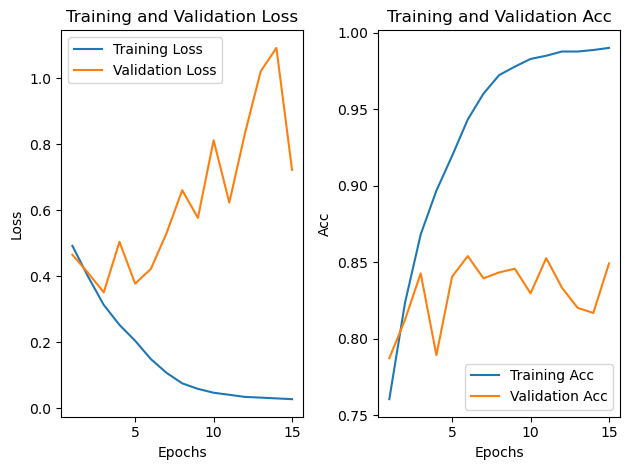


BEST VAL ACCURACY: 0.8501333333333333


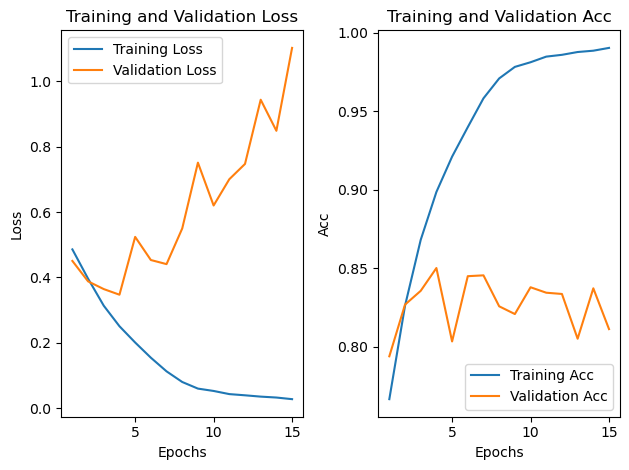


BEST VAL ACCURACY: 0.85


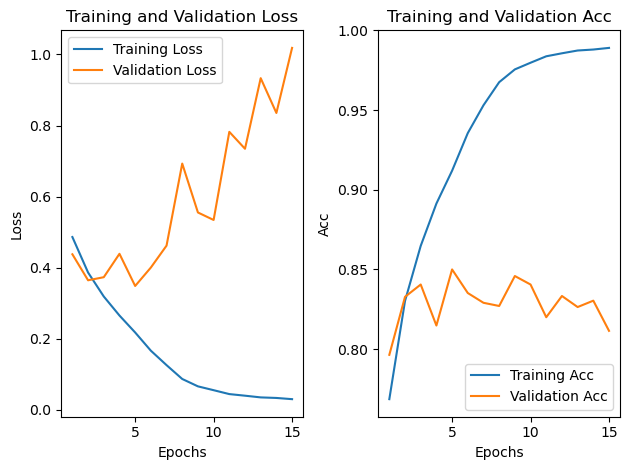


BEST VAL ACCURACY: 0.84


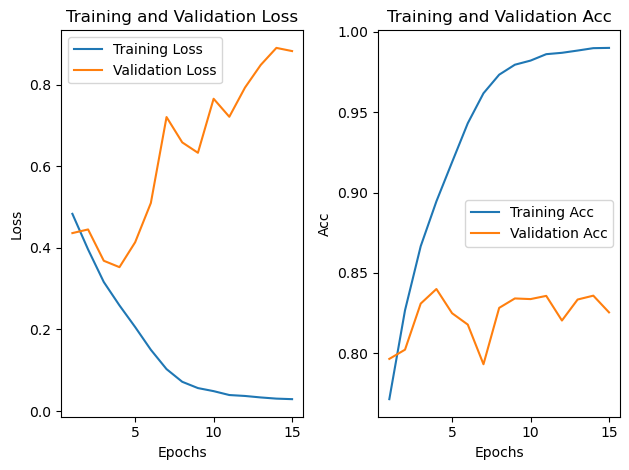


BEST VAL ACCURACY: 0.8546666666666667


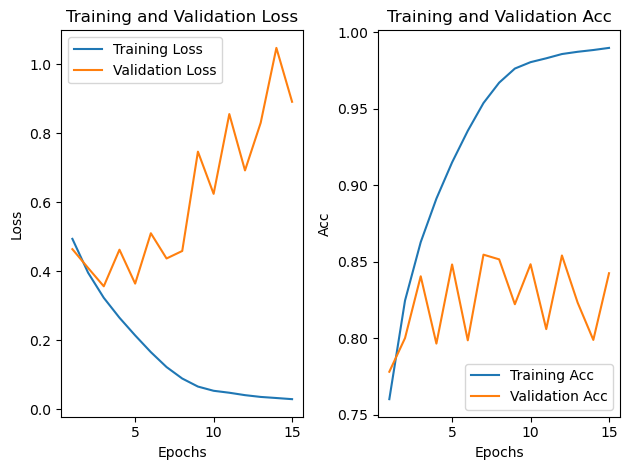

0.8497599999999998


In [ ]:
accs_fc = []
for _ in range(5):
    accs_fc.append(train_fc(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False))
print(sum(accs_fc)/len(accs_fc))


BEST VAL ACCURACY: 0.8373333333333334


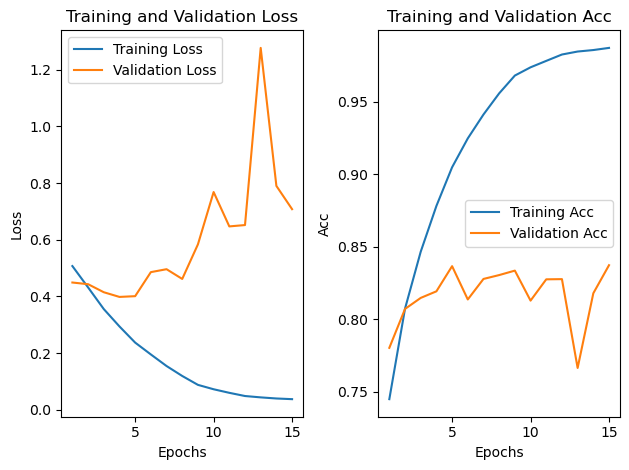


BEST VAL ACCURACY: 0.8456


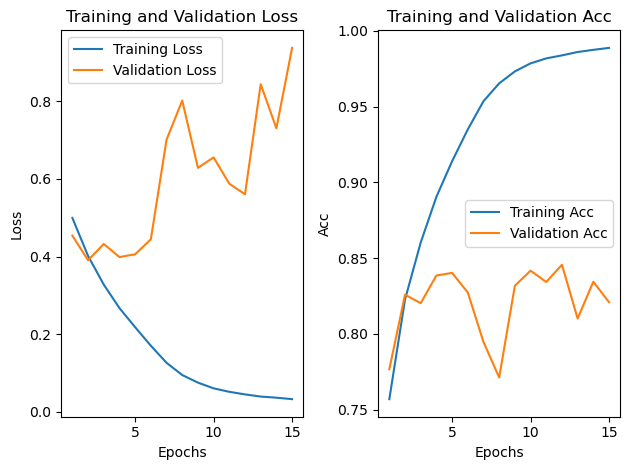


BEST VAL ACCURACY: 0.8368


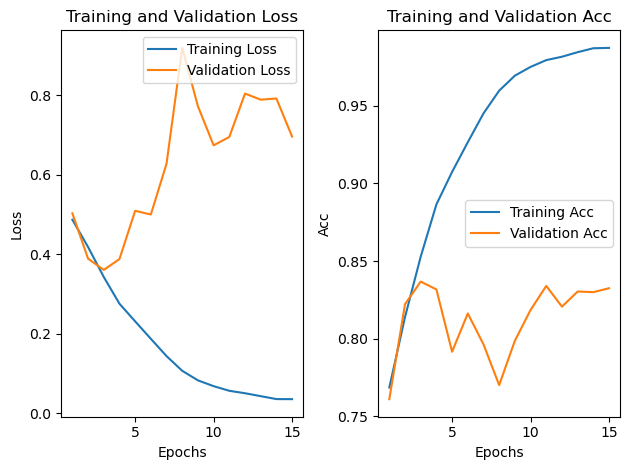


BEST VAL ACCURACY: 0.8484


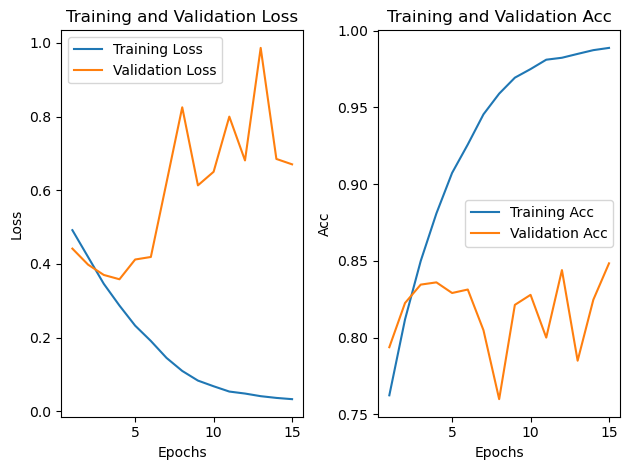


BEST VAL ACCURACY: 0.8472


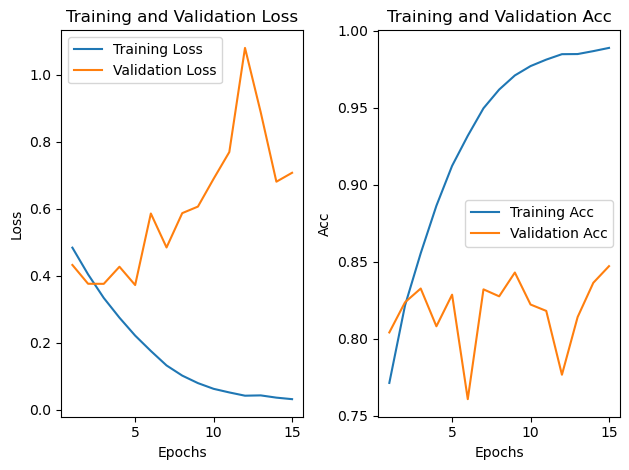

0.8430666666666667


In [ ]:
accs_rnn = []
for _ in range(5):
    accs_rnn.append(train_rnn(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False))
print(sum(accs_rnn)/len(accs_rnn))


BEST VAL ACCURACY: 0.8638666666666667


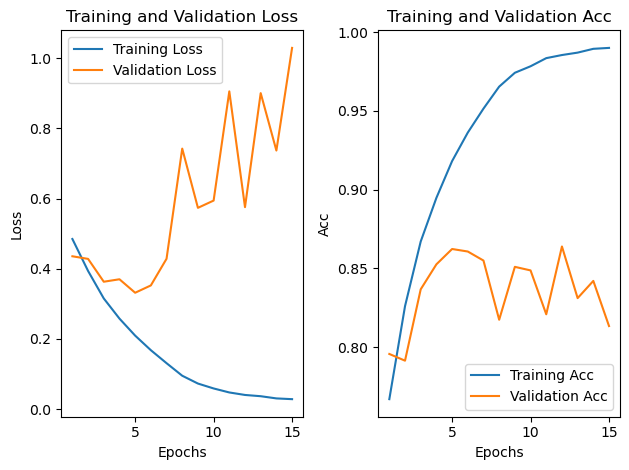


BEST VAL ACCURACY: 0.8581333333333333


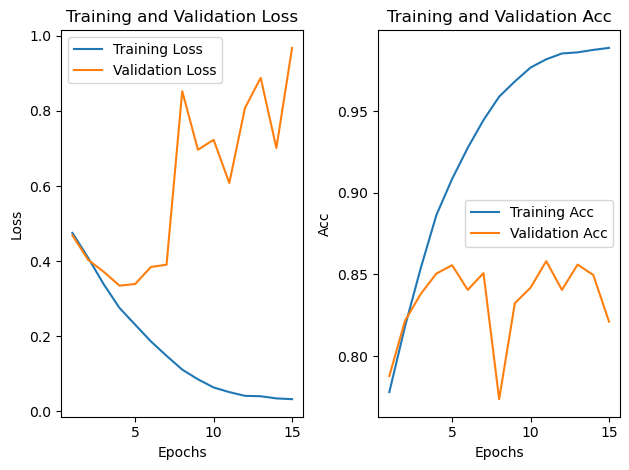


BEST VAL ACCURACY: 0.8630666666666666


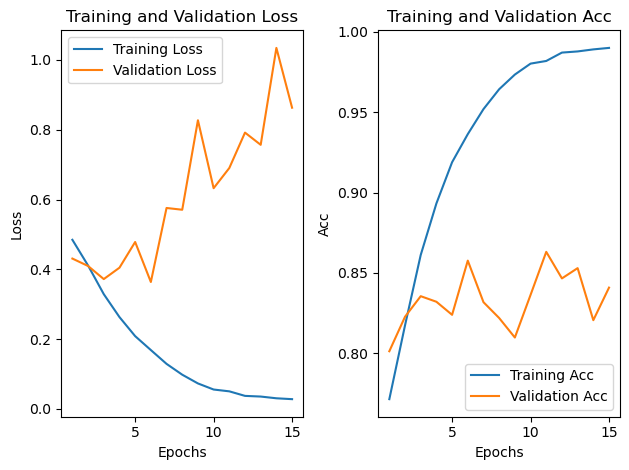


BEST VAL ACCURACY: 0.8566666666666667


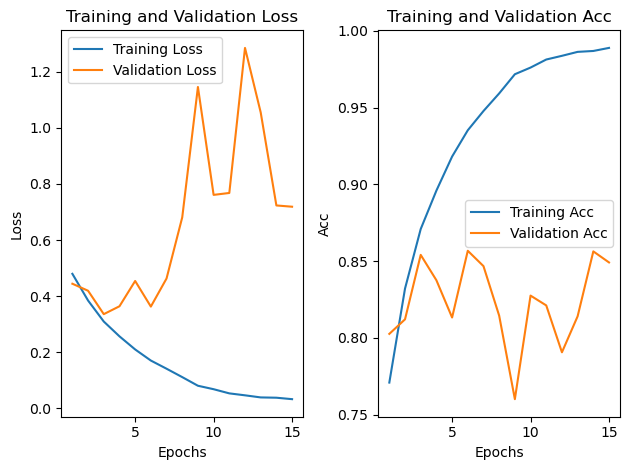


BEST VAL ACCURACY: 0.8713333333333333


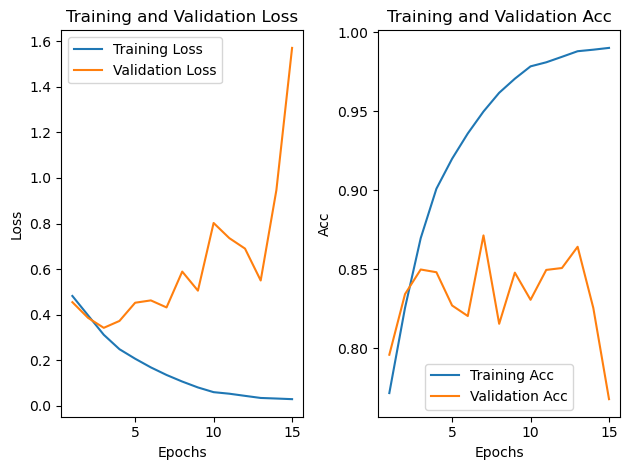

0.8626133333333333


In [ ]:
accs_lstm = []
for _ in range(5):
    accs_lstm.append(train_lstm(initial_channel_size=initial_channel_size, lr=lr, epochs=epochs, dropout=dropout, verbose=False))
print(sum(accs_lstm)/len(accs_lstm))